# Understanding the effects of COVID on the society in United States


## Table of contents
1. [Introduction](#Introduction)
2. [Background work](#Background-work)
3. [Data gathering and cleaning](#Data-gathering-and-cleaning)
4. [Research questions](#Research-questions)
5. [Methodology](#Methodology)
6. [Findings](#Findings)
7. [Limitations and implications](#Limitations-and-implications)
8. [Conclusion](#Conclusion)
9. [References](#References)

<span id="Introduction"/>

## Introduction

### Motivation

As SARS-CoV-2 is creating havoc in the world and affecting almost every country,the United States is currently the worst affected nation in the world. While it appears that everyone irrespective of their race and economic status is affected by the ill effects of the virus, I was curious to find out if that is true.

There are various different ways by which we can quantify the ill effects of COVID but the most obvious and severe effect is death.

Hence, I decided to study the death rates of COVID across various aspects like demographocs, unemployment, geographical area type and income ranges and observe if there are statistically significant differences in the mean death rates.

<span id="Background-work"/>

## Background work

There has already been some research and data points shared by CDC which show that there is some evidence of disproportionate death rate across different ethnic groups and gender. 
Below is the related CDC website that has links to other resources 

https://www.cdc.gov/coronavirus/2019-ncov/community/health-equity/race-ethnicity.html

The below two websites explores this in more details and shows a difference in death rates between various ethnic groups 

https://covidtracking.com/race 
https://covid.cdc.gov/covid-data-tracker/#demographics

Some of the resources explore the topic at a very high level and provide conclusion without enough information for a future scientist to explore.
While some provide more simplistic answers without diving deep into the details and studying interactions between different factors.

Hence although the work is interesting to get started, I still feel a lot more needs to be done in this area.

<span id="Data-gathering-and-cleaning"/>

## Data gathering and cleaning

In the below section we will collect data from various sources, clean it if required and then annotate the data.

But before doing that, we need to import all the dependencies required and create few helper methods.

If any of the packages do not exist, first we will install them. The below section will import any required packages. Please note that it is commented out as in most of the computers we will already have these required dependencies.

### Install required packages

In [1]:
# import sys
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install plotly
# !{sys.executable} -m pip install psutil
# !{sys.executable} -m pip install kaleido
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install wget
# !{sys.executable} -m pip install jupyter_contrib_nbextensions
# !{sys.executable} -m pip install yapf
# !{sys.executable} -m pip install statsmodels
# !{sys.executable} -m pip install sklearn


Now we will import the dependencies.

### Import dependencies
Below we import dependencies that are available on PyPi repository

In [2]:
import os
import json
import requests
import pandas as pd
from datetime import datetime
import plotly.express as px
import seaborn as sns
from scipy.stats import ttest_ind
import plotly.graph_objects as go
from scipy import stats
import matplotlib.pyplot as plt
import io
import requests
import sklearn
from sklearn import datasets, linear_model, multiclass, preprocessing
import wget
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
import math
import numpy as np

### Helper methods and constants
Next the below section creates few commonly used helper methods. Please note that the helper methods are required at different places and in different steps throughout the code and we want to define them at a single place before diving into the questions so that the rest of the code is easier to read.

The below method returns the extension of the file present at the url.

In [3]:
def get_extension(url):
    return os.path.splitext(url)[1]

Some of the files that we are dealing with are huge and in the order of 160MB. We want to avoid re pulling them from the source for better performance and hence we will cache it inside a folder names `data`.
The below method will pull the data from the passed in url, will cache locally and will return the local file path.

In [4]:
def get_cached_file(url):
    firstpos = url.rfind("/")
    lastpos = len(url)
    file_name = url[firstpos + 1:lastpos]
    local_file_path = os.path.join("data", file_name)
    if not os.path.exists(local_file_path):
        wget.download(url, local_file_path)

    return local_file_path

The `handle_commas` method will help in converting integers with commas in them to an integer type after removing commas. Example `20,000` will become `20000`

In [5]:
def handle_commas(df, col_name):
    df[col_name] = [int(x.replace(',', '')) for x in df[col_name]]
    df[col_name] = df[col_name].astype(int)
    return df

The below method will return a query string that will help in filtering out outliers by accepting a key and upper and lower bounds. This can be used in `Dataframe.query` method.

In [6]:
def outlier_trimming(lower, upper, key):
    return ' {key}<={upper_val} & {key}>={lower_val}'.format(
        key=key, upper_val=upper[key], lower_val=lower[key])

Some of the charts are not rendered correctly on github. Hence we will save them as png.

However, if you are using jupyter notebook, we might want to set this to `False` and get a proper interactive visualization.

In [7]:
IS_LOCAL_RENDER=True

The below method will either show an interactive or non-interactive graph based on `IS_LOCAL_RENDER`

In [8]:
def show(fig):
    if IS_LOCAL_RENDER:
        fig.show("png")
    else:
        fig.show()

### Collect ethnicity and gender data at county level

Ethnicity and gender data at county level are available at [county census](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html) website


[This](https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf) is the file that describes the various fields in the datasets

Here, we are interested in the data for latest year. The latest year available is 2019

To get the latest data for 2019, we need to pull data where YEAR=12

In [9]:
url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv"
tmp = get_cached_file(url)
demo_df = pd.read_csv(tmp, encoding='latin-1')
demo_df_year_filtered = demo_df.query("YEAR==12")

Next, we will filter out the data to get only the required columns.
We are interested in the below columns for our analysis

|Column Name   |Meaning   |
| :------------ | :------------ |
|STATE   |FIPS code for the state   |
|COUNTY   |FIPS code for the county   |
|AGEGRP   |The age group of the population   |
|WA_MALE   |White alone male population   |
|WA_MALE   |White alone male population   |
|WA_FEMALE   |White alone female population   |
|BA_MALE   |Black or African American alone male population   |
|BA_FEMALE   |Black or African American alone female population   |
|IA_MALE   |American Indian and Alaska Native alone male population   |
|IA_FEMALE   |American Indian and Alaska Native alone female population   |
|AA_MALE   |Asian alone male population   |
|NA_MALE   |Native Hawaiian and Other Pacific Islander alone male population   |
|NA_FEMALE   |Native Hawaiian and Other Pacific Islander alone female population   |

The idea here is that `STATE` and `COUNTY` are the primary keys for our dataset. We are not interested to differentiate across age groups and hence we will group by and sum across all age groups.

In [10]:
demo_interesting_columns = [
    'STATE', 'COUNTY', 'CTYNAME', 'STNAME', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
    'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
    'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE'
]

demo_filtered = demo_df_year_filtered[demo_interesting_columns]

demo_grouped = demo_filtered.groupby(['STATE', 'COUNTY', 'CTYNAME',
                                      'STNAME']).sum().reset_index()

We have populations for each demographics at county level. However, this is not really comparable as the county populations are different. Hence we would like to get to a unit that can be compared across multiple counties.

We will therefore take proportions of various demographic groups.

In [11]:
demo_grouped['white_male'] = demo_grouped['WA_MALE'] / demo_grouped['TOT_POP']
demo_grouped[
    'white_female'] = demo_grouped['WA_FEMALE'] / demo_grouped['TOT_POP']

demo_grouped['black_male'] = demo_grouped['BA_MALE'] / demo_grouped['TOT_POP']
demo_grouped[
    'black_female'] = demo_grouped['BA_FEMALE'] / demo_grouped['TOT_POP']

demo_grouped[
    'americanindian_male'] = demo_grouped['IA_MALE'] / demo_grouped['TOT_POP']
demo_grouped['americanindian_female'] = demo_grouped[
    'IA_FEMALE'] / demo_grouped['TOT_POP']

demo_grouped['asian_male'] = demo_grouped['AA_MALE'] / demo_grouped['TOT_POP']
demo_grouped[
    'asian_female'] = demo_grouped['AA_FEMALE'] / demo_grouped['TOT_POP']

demo_grouped['hawaai_male'] = demo_grouped['NA_MALE'] / demo_grouped['TOT_POP']
demo_grouped[
    'hawaai_female'] = demo_grouped['NA_FEMALE'] / demo_grouped['TOT_POP']

demo_grouped['white'] = (demo_grouped['WA_MALE'] +
                         demo_grouped['WA_FEMALE']) / demo_grouped['TOT_POP']
demo_grouped['black'] = (demo_grouped['BA_MALE'] +
                         demo_grouped['BA_FEMALE']) / demo_grouped['TOT_POP']
demo_grouped['americanindian'] = (
    demo_grouped['IA_MALE'] +
    demo_grouped['IA_FEMALE']) / demo_grouped['TOT_POP']
demo_grouped['asian'] = (demo_grouped['AA_MALE'] +
                         demo_grouped['AA_MALE']) / demo_grouped['TOT_POP']
demo_grouped['hawaain'] = (demo_grouped['NA_MALE'] +
                           demo_grouped['NA_FEMALE']) / demo_grouped['TOT_POP']

demo_grouped['male'] = (demo_grouped['WA_MALE'] + demo_grouped['BA_MALE'] +
                        demo_grouped['IA_MALE'] + demo_grouped['AA_MALE'] +
                        demo_grouped['NA_MALE']) / demo_grouped['TOT_POP']

demo_grouped['female'] = (
    demo_grouped['WA_FEMALE'] + demo_grouped['BA_FEMALE'] +
    demo_grouped['IA_FEMALE'] + demo_grouped['AA_FEMALE'] +
    demo_grouped['NA_FEMALE']) / demo_grouped['TOT_POP']

Next we will filter out only the interesting columns that will help us analyze our impact on society. Since we want to join with other datasets, we will keep a list of interesting columns in `demo_final_columns`

In [12]:
demo_final_columns = [
    'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'white_male', 'white_female',
    'black_male', 'black_female', 'americanindian_male',
    'americanindian_female', 'asian_male', 'asian_female', 'hawaai_male',
    'hawaai_female', 'white', 'black', 'americanindian', 'asian', 'hawaain',
    'male', 'female', 'TOT_POP'
]

demographics_final = demo_grouped[demo_final_columns]

Every state has a unique fips code and so does every county have a unique fips code within a state. Combining both the state level and county level FIPS code is enough to identify any county uniquely in the United States. Below we will combine them into a unique `FIPSCODE`

In [13]:
demographics_final['FIPSCODE'] = demographics_final.apply(
    lambda row: str(row.STATE) + str(row.COUNTY).zfill(3), axis=1)
demographics_final['FIPSCODE'] = demographics_final['FIPSCODE'].astype(int)

Next, we will download the COVID death information provided by CDC at county level and join it with demographics information on `FIPSCODE`
More details about this dataset can be found [here](https://catalog.data.gov/dataset/provisional-covid-19-death-counts-in-the-united-states-by-county)
The above dataset has columns on percentage of deaths for a certain race. However, in my analysis I observed that all the percentages do not add up to 100% for a county. Which might suggest that there is considerable amount of death data that does not have race information. Hence for having a more correct analysis, I decided not to use the percentage of death for a certain race.

Note: For ease of replication, we have downloaded the same data on December 5th, 2020

In [14]:
covid_deaths_path = "data/Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv"
deaths_df = pd.read_csv(get_cached_file(covid_deaths_path))
deaths_df['covid19_deaths'] = deaths_df['Deaths involving COVID-19']
deaths_df['all_deaths'] = deaths_df['Deaths from All Causes']
deaths_df['urban_rural'] = deaths_df['Urban Rural Code']
demo_final_columns = demo_final_columns + [
    'covid19_deaths', 'all_deaths', 'urban_rural', 'FIPSCODE'
]
demo_deaths_df = demographics_final.merge(
    deaths_df, how='inner', left_on='FIPSCODE',
    right_on='FIPS County Code')[demo_final_columns]

Next, since all county sizes are different, we will normalize the deaths to a value `covid19_deaths_per_10k` which indicates deaths due to covid 19 per 10K population. This gives us some meaningful way to interpret the number.

We also have another column `all_deaths_per_10k` which represents all deaths per 10k population.

In [15]:
demo_deaths_df['covid19_deaths_per_10k'] = (demo_deaths_df['covid19_deaths'] *
                                            10000) / demo_deaths_df['TOT_POP']
demo_deaths_df['all_deaths_per_10k'] = (demo_deaths_df['all_deaths'] *
                                        10000) / demo_deaths_df['TOT_POP']

if 'covid19_deaths' in demo_final_columns:
    demo_final_columns.remove('covid19_deaths')
if 'all_deaths' in demo_final_columns:
    demo_final_columns.remove('all_deaths')
demo_final_columns.append('covid19_deaths_per_10k')
demo_final_columns.append('all_deaths_per_10k')
demo_deaths_df = demo_deaths_df[demo_final_columns]

Next, we shall download and use the poverty and unemployment data from [here](https://www.ers.usda.gov/data-products/county-level-data-sets/)
Below are few columns that we will use and the transformations that we will perform.

`POVALL_2018`
This contains number of people under poverty in the year 2018. We will transform this to `pov_per_10k` which is a normalized version and indicates poverty per 10K of population.

`Unemployed_2019`
This contains number of adults that are unemployed in the year 2019. We will transform this to `unemployed_per_10k` which is a normalized version and indicates number of unemployed adults per 10K of population.

`Median_Household_Income_2018`
This is the median household income for a family of more than 2 for the year of 2018.

There are few other columns that maybe useful for performing EDA but they are not decisive in the final outcome.

In [16]:
poverty_df = pd.read_csv("data/PovertyEstimates.csv")

poverty_df.head()

demo_final_columns.append('POVALL_2018')
demo_deaths_pov_df = demo_deaths_df.merge(
    poverty_df, how='inner', left_on='FIPSCODE',
    right_on='FIPStxt')[demo_final_columns]

demo_deaths_pov_df = handle_commas(demo_deaths_pov_df, 'POVALL_2018')

demo_deaths_pov_df['pov_per_10k'] = (demo_deaths_pov_df['POVALL_2018'] *
                                     10000) / demo_deaths_pov_df['TOT_POP']

if 'POVALL_2018' in demo_final_columns:
    demo_final_columns.remove('POVALL_2018')

demo_final_columns.append('pov_per_10k')
demo_deaths_pov_df = demo_deaths_pov_df[demo_final_columns]

unemployment_df = pd.read_csv("data/Unemployment.csv")

unemployment_df['Employed_2019'] = unemployment_df[' Employed_2019 ']
unemployment_df['Unemployed_2019'] = unemployment_df[' Unemployed_2019 ']

if 'Employed_2019' not in demo_final_columns:
    demo_final_columns.append('Employed_2019')

if 'Unemployed_2019' not in demo_final_columns:
    demo_final_columns.append('Unemployed_2019')
demo_final_columns.append('Median_Household_Income_2018')
demo_deaths_pov_emp_df = demo_deaths_pov_df.merge(
    unemployment_df, how='inner', left_on='FIPSCODE',
    right_on='FIPStxt')[demo_final_columns]

demo_deaths_pov_emp_df = handle_commas(demo_deaths_pov_emp_df, 'Employed_2019')
demo_deaths_pov_emp_df = handle_commas(demo_deaths_pov_emp_df,
                                       'Unemployed_2019')

demo_deaths_pov_emp_df['employed_per_10k'] = (
    demo_deaths_pov_emp_df['Employed_2019'] *
    10000) / demo_deaths_pov_emp_df['TOT_POP']
demo_deaths_pov_emp_df['unemployed_per_10k'] = (
    demo_deaths_pov_emp_df['Unemployed_2019'] *
    10000) / demo_deaths_pov_emp_df['TOT_POP']

if 'Employed_2019' in demo_final_columns:
    demo_final_columns.remove('Employed_2019')
if 'Unemployed_2019' in demo_final_columns:
    demo_final_columns.remove('Unemployed_2019')
demo_final_columns.append('employed_per_10k')
demo_final_columns.append('unemployed_per_10k')
demo_final_columns.append('covid_deaths_sqr')
demo_final_columns.append('median_income')
demo_final_columns.append('median_income_bins')
demo_deaths_pov_emp_df = handle_commas(demo_deaths_pov_emp_df,
                                       'Median_Household_Income_2018')
demo_deaths_pov_emp_df['median_income'] = demo_deaths_pov_emp_df[
    'Median_Household_Income_2018'] * demo_deaths_pov_emp_df[
        'Median_Household_Income_2018']
demo_deaths_pov_emp_df['median_income_bins'] = 0
demo_deaths_pov_emp_df['covid_deaths_sqr'] = demo_deaths_pov_emp_df[
    'covid19_deaths_per_10k'] * demo_deaths_pov_emp_df['covid19_deaths_per_10k']
demo_deaths_pov_emp_df = demo_deaths_pov_emp_df[demo_final_columns]
demo_deaths_pov_emp_df['black_to_white'] = demo_deaths_pov_emp_df[
    'black'] / demo_deaths_pov_emp_df['white']

<span id="Research-questions"/>

## Research questions

- Is the mean death rate of people dying with COVID in United States the same across different geographical area types?

- Is the mean death rate of people dying with COVID in United States the same across all income groups?

- Is the mean death rate of people dying with COVID in United States the same across all races?

For each of these, we will do some basic EDA and then use relevant statistical tests to come up with conclusion. While answering the above questions, if we find interesting patterns, we will dive deep into each one of them.
We might also be interested to study any interactions between these factors.

<span id="Methodology"/>

## Methodology
In order to study the effects of covid on the society, we will first need to do some exploratory data analysis to understand at high level criteria and then we shall dig deeper into each question.
We will also do statistical tests to validate our observations.

Before that we need to handle outliers and make the data easy to interpret

### Handling Outliers
We will remove outliers that may adversely affect our analysis.
Removal of outliers is acceptable here as we want to do an analysis that is more applicable to as much of the the population and not skew it due to abnormal counties.
Also, even after outlier removal we have enough sample size for our tests to be statistically significant.

In [17]:
upper_quantile = demo_deaths_pov_emp_df.quantile(0.98)
lower_quantile = demo_deaths_pov_emp_df.quantile(0.02)

outlier_cols = [
    'black', 'white', 'Median_Household_Income_2018', 'covid19_deaths_per_10k'
]
outlier_query = [
    outlier_trimming(lower_quantile, upper_quantile, c) for c in outlier_cols
]
query_str = ' & '.join(outlier_query)

demo_deaths_pov_emp_df_plottable = demo_deaths_pov_emp_df.query(query_str)

Now, `demo_deaths_pov_emp_df_plottable` contains all the data after removing outliers.

### Making data easy to interpret

The `Median_Household_Income_2018` contains the median household income but the data is continuous and it is slightly difficult to interpret any results out of the data.

Hence we will try to divide the dataset into different classes.
Kindly note that there is no straight forward and well known standard for distributing United States counties based on economic data and hence I came up with a mechanism based on percentage of 2+ income households in different quintiles explained [here]

##### Fig 1

(https://en.wikipedia.org/wiki/Social_class_in_the_United_States#/media/File:Two_or_more_income_earners.png)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Two_or_more_income_earners.svg/440px-Two_or_more_income_earners.svg.png" width=200  />

There could be limitations to this binning and I have included that as part of the limitations section.

In [18]:
classes_values = [0, .0267, .094, .2042, .3085, .7716, 1]
classes_labels = [
    'bottom quintile', 'second quintile', 'middle quintile', 'fourth quintile',
    'top quintile', 'topmost quntile'
]
demo_deaths_pov_emp_df_plottable['median_income_bins'] = pd.qcut(
    demo_deaths_pov_emp_df_plottable['Median_Household_Income_2018'],
    labels=classes_labels,
    q=classes_values)

Lets also create a helper method that will be used later in findings section. This method will take in a formula, fit a ordinarly least square regression module and return the p-values and coefficients.


In [19]:
def extract_fit_data(formula, df=demo_deaths_pov_emp_df_plottable):
    fit = smf.ols(formula=formula, data=df).fit()
    return pd.DataFrame({'pvalues': fit.pvalues, 'coefficient': fit.params})

<span id="Findings"/>


## Findings

In the below section, we apply the methodology described in `Methodology` section to every question of interest.



### Is the mean death rate of people dying with COVID in United States the same across different geographical area types?
Here we will look at urban vs rural distribution and we will try to see if we find any patterns

##### Fig 2

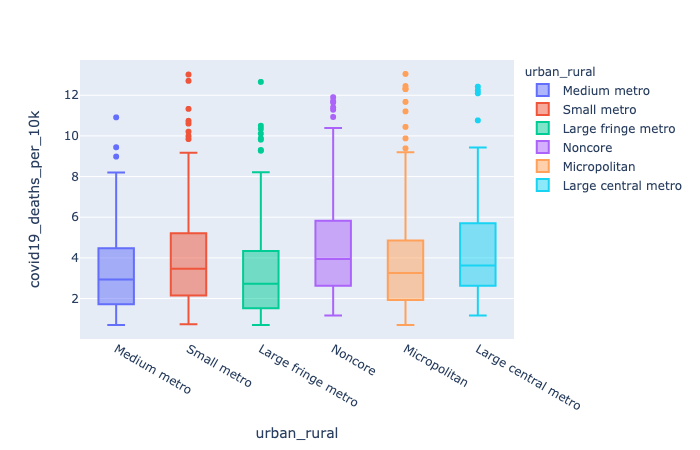

In [20]:
fig = px.box(demo_deaths_pov_emp_df_plottable,
             y='covid19_deaths_per_10k',
             color='urban_rural',
             x='urban_rural')
show(fig)

From the above visualization, it is not easy to conclude anything. Hence, we will run a linear regression and observe the p-value

In [21]:
extract_fit_data(formula='covid19_deaths_per_10k ~ urban_rural')

,pvalues,coefficient
Intercept,1.524221e-48,4.532430
urban_rural[T.Large fringe metro],9.435595e-05,-1.307858
urban_rural[T.Medium metro],2.337698e-04,-1.229204
urban_rural[T.Micropolitan],9.055406e-03,-0.838175
urban_rural[T.Noncore],9.660627e-01,-0.014315
urban_rural[T.Small metro],1.148826e-01,-0.528812


As we observe above, the model considered `Large central metro` as the reference level and calculated p-values with relation to that.
We observe that the p-values are different but few of them are much smaller than 0.05. Hence overall, we can conclude the below.

<b>The mean death rate of people dying with COVID in US is not same across all geographical areas.</b>

### Is the mean death rate of people dying with COVID in United States the same across all income groups?

First, we will look at the distributions for various levels

##### Fig 3

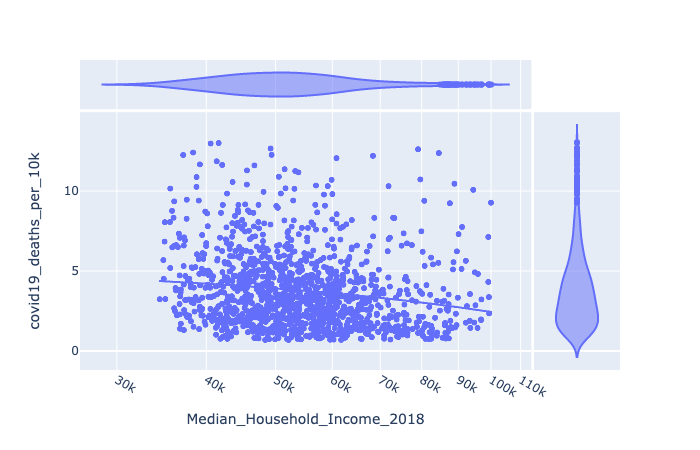

In [22]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 y='covid19_deaths_per_10k',
                 marginal_y="violin",
                 marginal_x="violin",
                 trendline="ols",
                 log_x=True,
                 x='Median_Household_Income_2018')
show(fig)

We see that there is a trend where the death rate decrease as the median household income increases.
Next, we will try to observe if the difference is statistically significant.

We will use linear regression and observe the p-values

In [23]:
extract_fit_data(
    formula='covid19_deaths_per_10k ~ Median_Household_Income_2018')

,pvalues,coefficient
Intercept,8.966440e-72,5.40750
Median_Household_Income_2018,3.612904e-09,-0.00003


We observe that the p-values are much lower than 0.05 hence we can conclude that the death rates are not same. We also observe that the coefficient is negative which indicates that the death rate decreases as the median household income increases.

<b> The mean death rate of people dying with COVID in US is not same across all counties with different median income. In fact it decreases as the median income increases.</b>

### Is the mean death rate of people dying with COVID in United States the same across all races?

The different races that we are interested in are
1. black
2. white
3. asian
4. american indian

The reason for picking these races is because we have sufficient data for all of these races.

Here we will first do a visual inspection and then we will apply tests if required


The below method will serve as a helper method to plot race information

In [24]:
def plot_chart(factor, color_col=None):
    factor = factor
    if color_col:
        fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                         x=factor,
                         y='covid19_deaths_per_10k',
                         color=color_col,
                         log_x=True,
                         trendline='ols',
                         trendline_color_override='black',
                         hover_name='CTYNAME')
        show(fig)
    else:
        fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                         x=factor,
                         y='covid19_deaths_per_10k',
                         log_x=True,
                         trendline='ols',
                         trendline_color_override='black',
                         hover_name='CTYNAME')
        show(fig)

#### Asian

##### Null Hypothesis
The mean death rate of counties is same if the proportion of asians increases or decreases.

##### Fig 4

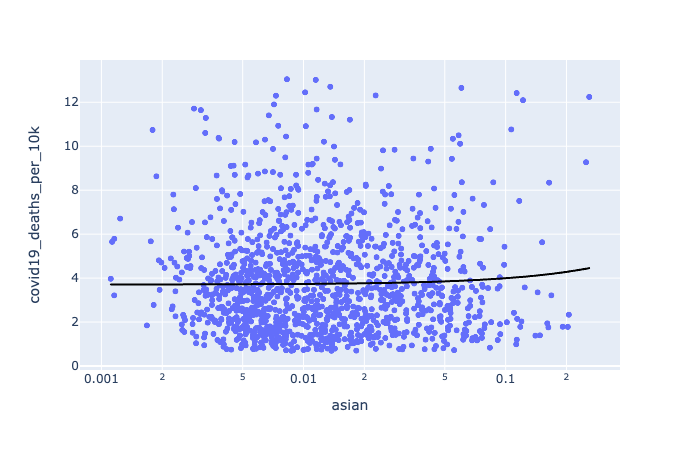

In [25]:
plot_chart('asian')

We observe that there is not really a clear pattern that we can see here.

Hence, next we will try to fit a linear regression

In [26]:
extract_fit_data(formula='covid19_deaths_per_10k ~ asian')

,pvalues,coefficient
Intercept,2.437905e-268,3.709122
asian,2.521758e-01,2.866771


The p-value is not lower than 0.05 and hence we fail to reject the null hypothesis.

#### American Indian

##### Null Hypothesis
The mean death rate of counties is same if the proportion of american indians increases or decreases.

##### Fig 5

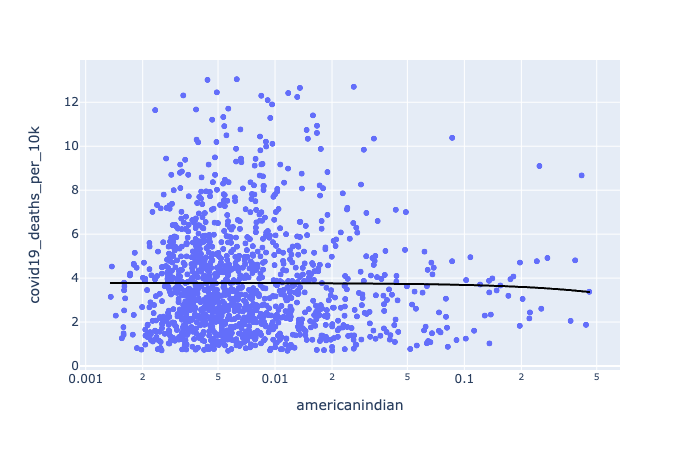

In [27]:
plot_chart('americanindian')

In [28]:
extract_fit_data(formula='covid19_deaths_per_10k ~ americanindian')

,pvalues,coefficient
Intercept,0.000000,3.780130
americanindian,0.617487,-0.905772


The p-value is not lower than 0.05 and hence we fail to reject the null hypothesis.

#### White

##### Null Hypothesis
The mean death rate of counties is same if the proportion of white race increases or decreases.

##### Fig 6

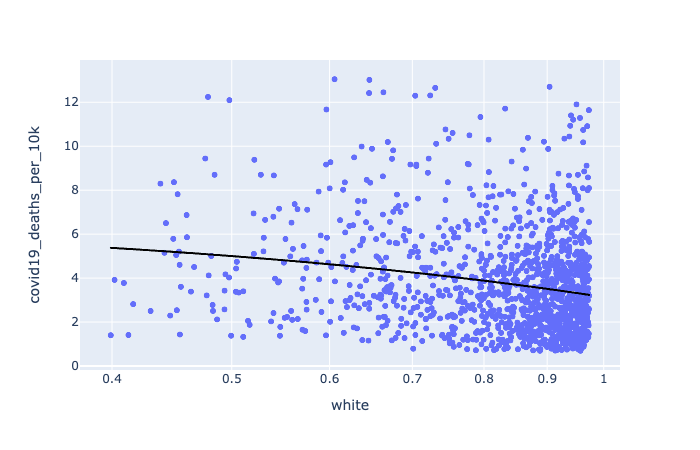

In [29]:
plot_chart('white')

In [30]:
extract_fit_data(formula='covid19_deaths_per_10k ~ white')

,pvalues,coefficient
Intercept,2.623947e-57,6.865725
white,3.573009e-14,-3.727345


The p-value is lower than 0.05 and hence we reject the null hypothesis.
We also observe that the coefficient is negative which indicates that the death rate decreases.

<b>The death rate of counties decreases if the proportion of white race increases.</b>

#### Black

##### Null Hypothesis
The mean death rate of counties is same if the proportion of black race increases or decreases.

##### Fig 7

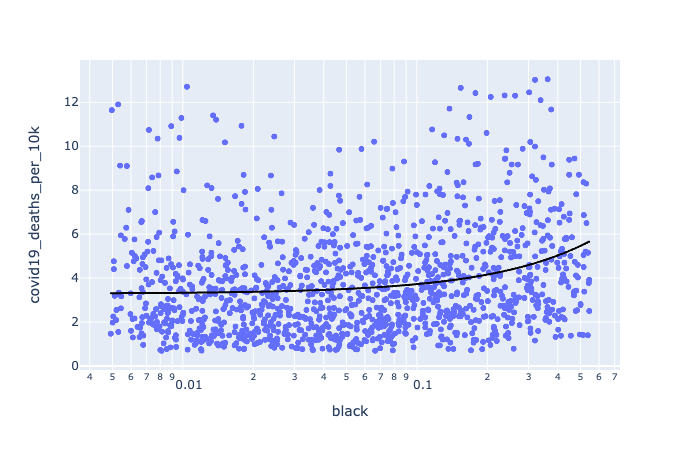

In [31]:
plot_chart('black')

As we observe the death rate due to COVID significantly increases as the proportion of blacks increases in the county.

In [32]:
extract_fit_data(formula='covid19_deaths_per_10k ~ black')

,pvalues,coefficient
Intercept,1.109792e-221,3.290976
black,3.786843e-17,4.350353


The p-value is lower than 0.05 and hence we reject the null hypothesis.
We also observe that the coefficient is positive which indicates that the death rate increases as the proportion of black race increases.

<b>The death rate of counties increases if the proportion of black race increases.</b>

### Additional analysis for black race

After the previous analysis we observed that the death rate increases as the proportion of black race increases. Also, the coefficient is reasonably high.

Hence, we are curious to understand other factors that may be influencing the death rates related to black race.

We shall consider the below variables along with black race and try to observe if there is any pattern that we see.

We will mostly be doing visualizations and only dig deeper if we see any interesting patterns.

#### Black race and unemployment

Lets try to observe if there is any relation between black race and unemployment per 10K.

We will construct a scatter plot and have unemployment plotted by color.

##### Fig 8

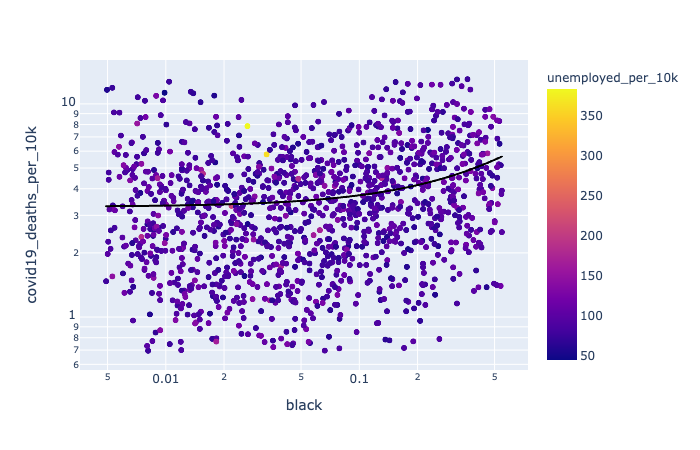

In [33]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 x='black',
                 y='covid19_deaths_per_10k',
                 color='unemployed_per_10k',
                 log_x=True,
                 log_y=True,
                 trendline='ols',
                 trendline_color_override='black',
                 hover_name='CTYNAME')
show(fig)

##### Statistical test

In [34]:
extract_fit_data(formula='covid19_deaths_per_10k ~ black+unemployed_per_10k')

,pvalues,coefficient
Intercept,4.223803e-37,3.413531
black,3.555860e-17,4.357107
unemployed_per_10k,6.182096e-01,-0.001361


We observe that the p-value above is greater than 0.05. Which shall be interpreted as below.

If we keep the proportion of black race constant, we do not see a statistically significant difference in the mean death rate associated with change in unemployment.

However, if we keep the unemployed per 10K constant, we do see a statistically significant increase in death rate as the proportion of black race increases.

#### Black race and geographic area

##### Fig 9

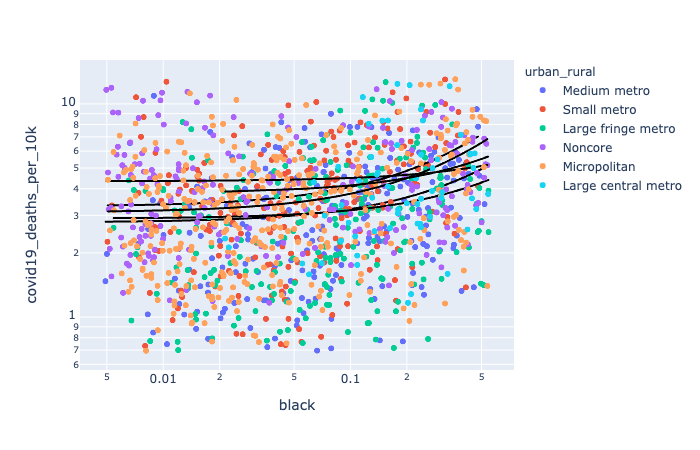

In [35]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 x='black',
                 y='covid19_deaths_per_10k',
                 color='urban_rural',
                 log_x=True,
                 log_y=True,
                 trendline='ols',
                 trendline_color_override='black',
                 hover_name='CTYNAME')
show(fig)

If we observe the above graph, we do see that for each area, there is certain increase in death rate as the proportion of black race increases.

The interaction based on geographic area and black race is not that interesting because there could be a lot of other confounding and influencing factors when we consider geography. Hence, we will not dive deeper into this analysis.

#### Black race and poverty

##### Fig 10

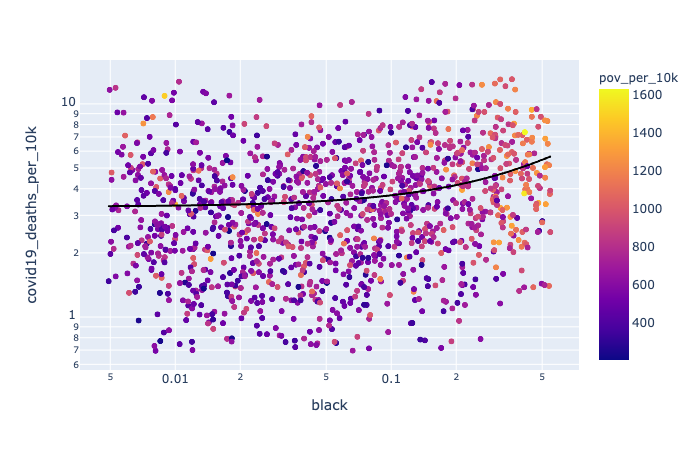

In [36]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 x='black',
                 y='covid19_deaths_per_10k',
                 color='pov_per_10k',
                 log_x=True,
                 log_y=True,
                 trendline='ols',
                 trendline_color_override='black',
                 hover_name='CTYNAME')
show(fig)

The above plot shows that as the proportion of black increases, poverty per 10K increases.

But to test the effect on death rate, we will need to do a test.

##### Statistical test

In [37]:
extract_fit_data(
    formula='covid19_deaths_per_10k ~ black+pov_per_10k+black*pov_per_10k')

,pvalues,coefficient
Intercept,1.661877e-20,2.501808
black,3.530485e-01,1.648833
pov_per_10k,3.912308e-04,0.001367
black:pov_per_10k,4.236559e-01,0.001566


The statistical test shows us that if we keep black race proportion constant, the mean death rate changes with change in poverty per 10K.

The test also proves that if we keep the poverty per 10K constant, the mean death rate changes with change in proportion of black race.

We also see observe that there is not a strong indication of any interaction.

#### Black race and median household income

##### Fig 11

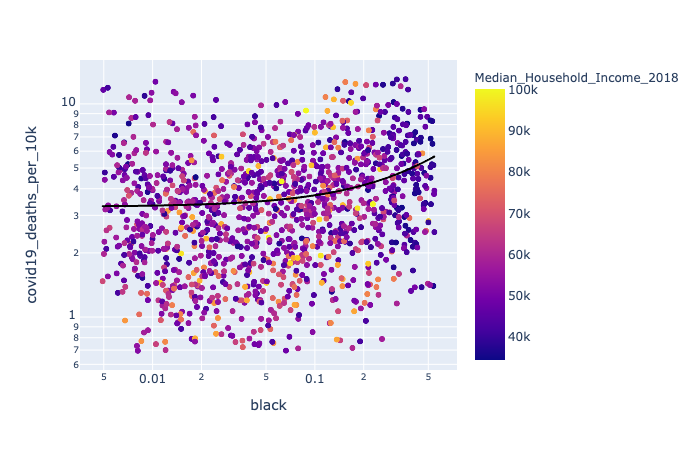

In [38]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 x='black',
                 y='covid19_deaths_per_10k',
                 color='Median_Household_Income_2018',
                 log_x=True,
                 log_y=True,
                 trendline='ols',
                 trendline_color_override='black',
                 hover_name='CTYNAME')
show(fig)

From the above visualization, it is not very clear about any patterns that exist with black race and median household income.

Hence, we will need to do a statistical test.

##### Statistical test


In [39]:
extract_fit_data(
    formula=
    'covid19_deaths_per_10k ~ black+Median_Household_Income_2018+black*Median_Household_Income_2018'
)

,pvalues,coefficient
Intercept,5.404484e-32,4.763783
black,3.696149e-01,1.928103
Median_Household_Income_2018,2.055762e-04,-0.000026
black:Median_Household_Income_2018,3.541297e-01,0.000039


The above test proves 2 things based on the p-values and coefficients

1. If we keep the proportion of black race constant, the mean death rate decreases as the median household income increases.
2. If we keep the median household income constant, we cannot statistically prove that the death rate increases with the increase in proportion of black race.

We also observed that there is not much proof of interaction between these 2 conditions.

#### Black race in context of different classes of counties

The result on black race and median household income was striking, but another thing that we can do further is
- Divide the counties into different buckets.
- Observe the relation between proportion of black race and deaths due to COVID

Note, there is no specific standard on which we can divide US counties. Hence, I am coming up with a pseudo mechanism described [here](#Making-data-easy-to-interpret).

This may not be the best way to classify counties but directionally, we may be able to observe patterns.

##### Fig 12

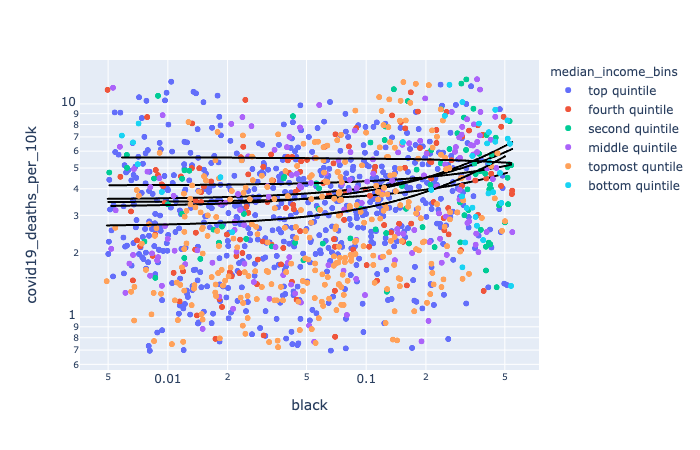

In [40]:
fig = px.scatter(demo_deaths_pov_emp_df_plottable,
                 x='black',
                 y='covid19_deaths_per_10k',
                 color='median_income_bins',
                 log_x=True,
                 log_y=True,
                 trendline='ols',
                 trendline_color_override='black',
                 hover_name='CTYNAME',
                 hover_data=['STNAME'])
show(fig)

In the above visualization, we have a surprising observation that the mean death rate is slightly lower as the proportion of black race increases in the poorest counties (bottom quintile)

However, in counties which have higher median income, the mean death rate increases with increase in proportion of black race.

Also, note that the mean death rate was already signficantly higher in poor counties.

This provides support to below conclusions
1. If a county is poor, the proportion of a race doesnt matter and the death rate is high.
2. For counties with moderate to high income ratios, the death rate increases as the proportion of black race increases.

Does it hence mean that median household income is the only factor and unfortunately counties with more people with black race have lower median incomes which is the reason we see higher death rates for counties with people with black race?

If the above statement is true, then we should also see a negative correlation between proportion of black race and median household income.

#### Correlation between black race and median income

In [41]:
np.corrcoef(demo_deaths_pov_emp_df_plottable['black'],
            demo_deaths_pov_emp_df_plottable['Median_Household_Income_2018'])

array([[ 1.        , -0.22097979],
       [-0.22097979,  1.        ]])

We do see a considerably strong negative correlation between proportion of black race and median household income.

If this is the case, then it is quiet possible that the deaths are really associated with factors associated with the lower income and not specifically related to any health conditions that people in black race might have.

It is not straightforward to prove this above hypothesis as we do not have any other health data. So, I would leave this as a probable hypothesis and would invite future data scientists to either prove me correct or wrong.

<span id="Limitations-and-implications"/>

## Limitations and implications

### Implications

Getting an understanding of the different factors affecting the death rate of different segments of the society will help governments mobilize resources with correct priorities.

Understanding about the death rates from race point of view will help future data scientists to dig deeper and analyze further on any other confounding factors.

Understanding the effects of race, unemployment and median income on a pandemic will be useful for future pandemics.

Government could use this information for vaccine prioritization.

### Limitations

1. Ethnicity and gender data at county level is available only for 2019. The assumption here is that there is not a big difference in population statistics in a year.
2. Out of the 3143 counties, we have covid death data only from 1486 counties.
3. Poverty data is available only for 2018 and unemployment data for 2019, but my assumption here is there may not be a lot of change in these datasets in the last 2 years.
4. My mechanism to bin the counties based on median household income is something that I came up with and might not represent the real way a society works.

<span id="Conclusion"/>

## Conclusion

Below are some conclusions and observations

- The mean death rate of people dying with COVID in United States is not the same across different geographical area types.

- The mean death rate of people dying with COVID is not the same in United States across all income groups.

- The mean death rate of people dying with COVID is not the same in United States across all races.

We observed that the mean death rate increased as the proportion of black race increased in the counties.
Hence we did some further analysis to see if we can find any more information on the above observation.

We found that
1. If we keep the proportion of black race constant, the mean death rate decreases as the median household income increases.
2. If we keep the median household income constant, we cannot statistically prove that the death rate increases with the increase in proportion of black race.

One important observation we have is, if you are poor, ethnicity is not a deciding factor for the deaths. Counties with low proportion of black race and high proportion of black race have similar death rates. Observe <B>Figure 12</B>

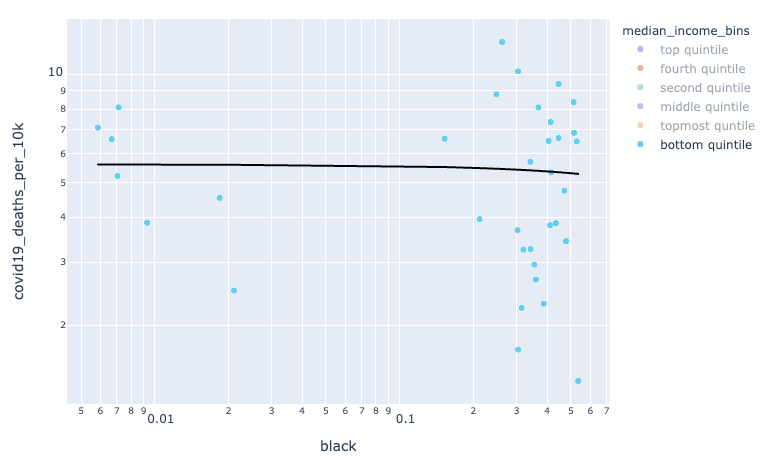

However for middle class and upper class Americans, if a county contains more black proportions, it would have more deaths compared to counties containing more white proportion.

Hence, we wanted to observe the correlation between proportion of black population and median household income and we observed a reasonably high negative correlation between proportion of black race and median household income of -0.22.

This indicates that the real reason behind a higher death rate for black population is really due to falling in lower median income group. It could be possible that in those counties, associated risks like health care facilities and quality of life. 

However, we need more data to conclude this with certainty.

<span id="References"/>

## References


Below are the datasets. All of them contain data at county level and all the data is available on public domain.

#### Census data at county level

https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

Click on United States

https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv

This contains the demographics information.


#### Economic research data at county level

https://www.ers.usda.gov/data-products/county-level-data-sets/

The above dataset contains poverty and unemployment data. This has been downloaded in the `data/` folder for ease of analysis.

#### Covid deaths data

https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-County-and-Ra/k8wy-p9cg

#### Information of social classes in United States
https://en.wikipedia.org/wiki/Social_class_in_the_United_States#/media/File:Two_or_more_income_earners.png
